In [1]:
import warnings; warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import optimize as opt

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set(style="darkgrid")

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.metrics import accuracy_score

In [2]:
# load data
data=pd.read_csv('machine-learning-ex2/ex2/ex2data2.txt',
                 header=None,names=['microchip_test1','microchip_test2','target'])

display(data.head())
data.shape

,microchip_test1,microchip_test2,target
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


(118, 3)

In [3]:
# split dataframe into X vs. y and convert them into numpy arrays for vectorized operations
y=data.filter(['target'],axis=1).values
X=data.drop(['target'],axis=1).values

print(y[:5,])
print(X[:5,])

[[1]
 [1]
 [1]
 [1]
 [1]]
[[ 0.051267  0.69956 ]
 [-0.092742  0.68494 ]
 [-0.21371   0.69225 ]
 [-0.375     0.50219 ]
 [-0.51325   0.46564 ]]


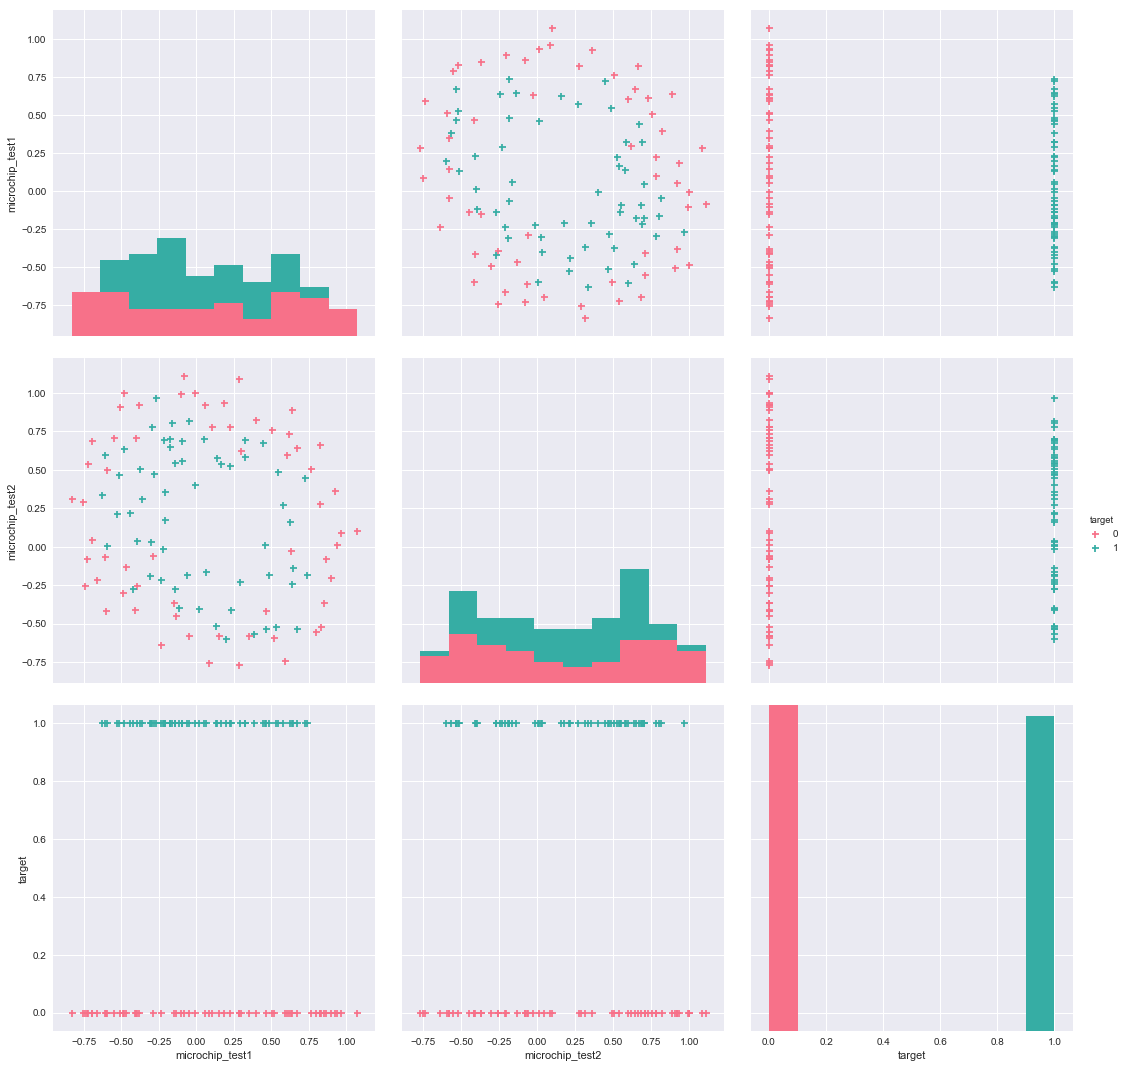

In [4]:
# visualize the data
sns.pairplot(data,hue='target',markers='+',palette='husl',size=5);

In [5]:
# approach 1: feature construction using sklearn wrapper
pf=PolynomialFeatures(degree=6)
X_poly=pf.fit_transform(X)

In [6]:
# approach 2: ground-up polynomial feature construction (to be completed...)

In [7]:
# construct sigmoid function
def sigmoid(x):
    return 1/(1+np.exp(-x))

# construct regularized cost function and gradient
def cost_ftn(theta,X,y,alpha):
    sample_size=X.shape[0]
    lc=np.dot(X,theta)
    cost=-sum(y*np.log(sigmoid(lc))+(1-y)*np.log(1-sigmoid(lc)))/sample_size\
    +alpha/(2*sample_size)*np.dot(theta[1:].T,theta[1:])
    return cost.ravel()

def gradient(theta,X,y,alpha):
    sample_size=X.shape[0]
    lc=np.dot(X,theta)
    delta=sigmoid(lc)-y
    theta=np.insert(theta[1:],0,0).reshape(len(theta),1)
    gradient=np.dot(X.T,delta)/sample_size+alpha/sample_size*theta
    return gradient.ravel()

In [8]:
# test cost function and gradient
theta_initial=np.zeros((X_poly.shape[1],1))
cost_initial=cost_ftn(theta_initial,X_poly,y,1)
gradient_initial=gradient(theta_initial,X_poly,y,1)

print("Cost at initial theta of zeros: {0:.3f}".format(np.asscalar(cost_initial)))
print("Gradient (first five) at initial theta of zeros:")
print(np.round(gradient_initial[:5],4))

theta_test=np.ones((X_poly.shape[1],1))
cost_test=cost_ftn(theta_test,X_poly,y,10)
gradient_test=gradient(theta_test,X_poly,y,10)

print("\nCost at test theta: {0:.3f}".format(np.asscalar(cost_test)))
print("Gradient (first five) at test theta:")
print(np.round(gradient_test[:5],4))

Cost at initial theta of zeros: 0.693
Gradient (first five) at initial theta of zeros:
[ 0.0085  0.0188  0.0001  0.0503  0.0115]

Cost at test theta: 3.165
Gradient (first five) at test theta:
[ 0.346   0.1614  0.1948  0.2269  0.0922]


In [9]:
# optimization using sklearn API (this approach produces same results as MatLab version)
def get_lr_coef(C):
    lr=LogisticRegression(solver='newton-cg',C=C)
    lr.fit(X_poly[:,1:],y)
    coef_lr=lr.coef_.reshape(X_poly[:,1:].shape[1],1)
    inter=lr.intercept_.reshape(1,1)
    coef_lr=np.concatenate([inter,coef_lr],axis=0)
    return coef_lr

In [10]:
# construct function for drawing decision boundary
def decision_boundary(theta):
    x0=np.linspace(-1,1.6,50)
    x1=np.linspace(-1,1.6,50)
    combined=np.array([(i,j) for i in x0 for j in x1])
    z=np.dot(pf.transform(combined),theta)
    z=np.array(np.split(z,50,axis=0)).reshape(50,50).T
    plt.contour(x0,x1,z,[0],linewidth=2)

# scatter plot wrapper
def plot(theta,alpha_label):
    sns.lmplot('microchip_test1','microchip_test2',data,hue='target',fit_reg=False,size=8)
    plt.title('Decision Boundary with Regularization Strength = '+str(alpha_label))
    decision_boundary(theta)

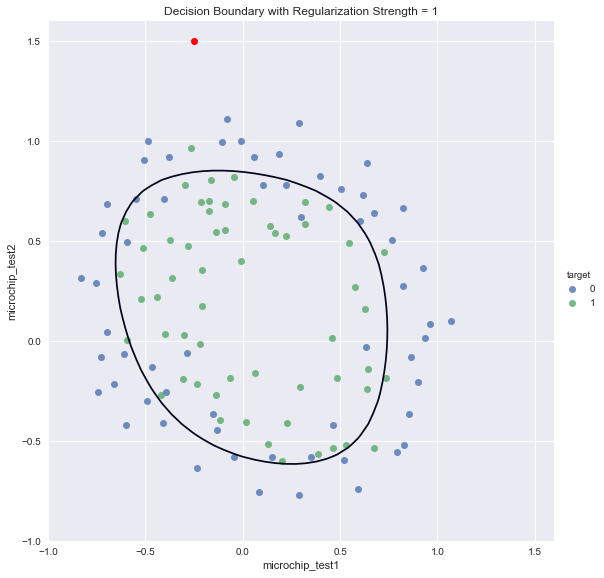

In [11]:
# plot decision boundary with regularization strength of 1
coef_reg_1=get_lr_coef(C=1)
plot(coef_reg_1,1)
plt.plot(-0.25,1.5,'ro');

In [12]:
# predict probability of acceptance for a new sample using sklearn API
lr=LogisticRegression(solver='newton-cg')
lr.fit(X_poly[:,1:],y)
x=pf.transform(np.array([-0.25,1.5]).reshape(1,2))
predicted_prb=np.asscalar(lr.predict_proba(x[:,1:])[:,1])

print('Probability of acceptance: {}'.format(predicted_prb))

# calculate accuracy using sklearn API
predicted=lr.predict(X_poly[:,1:])
score=accuracy_score(y,predicted)*100

print('Accuracy score: {0:.1f}%'.format(score))

Probability of acceptance: 2.1548337926041807e-09
Accuracy score: 83.1%


In [13]:
# same result as calculated using our functions
predicted_prb=np.asscalar(sigmoid(np.dot(x,coef_reg_1)))

print('Probability of acceptance: {}'.format(predicted_prb))

predicted_prb=sigmoid(np.dot(X_poly,coef_reg_1))
predicted=(predicted_prb>=0.5).astype(int)
score=np.mean(predicted.reshape(X_poly.shape[0],1)==y)*100

print('Accuracy score: {0:.1f}%'.format(score))

Probability of acceptance: 2.154833792604188e-09
Accuracy score: 83.1%


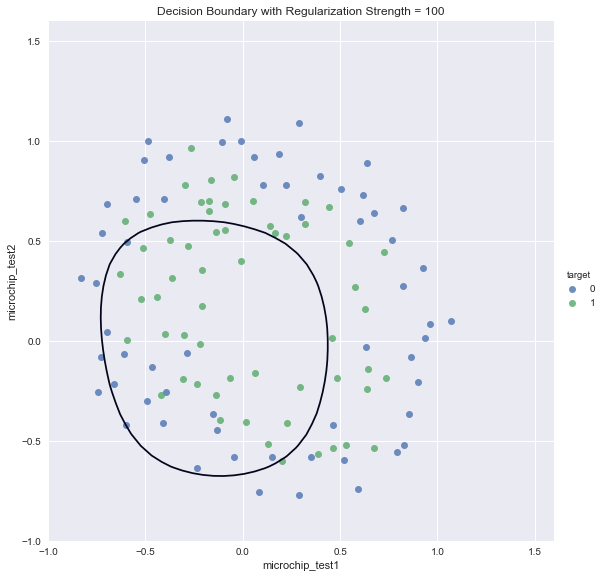

In [14]:
# plot decision boundary for regularization strength = 100
coef_reg_100=get_lr_coef(C=0.01)
plot(coef_reg_100,100)

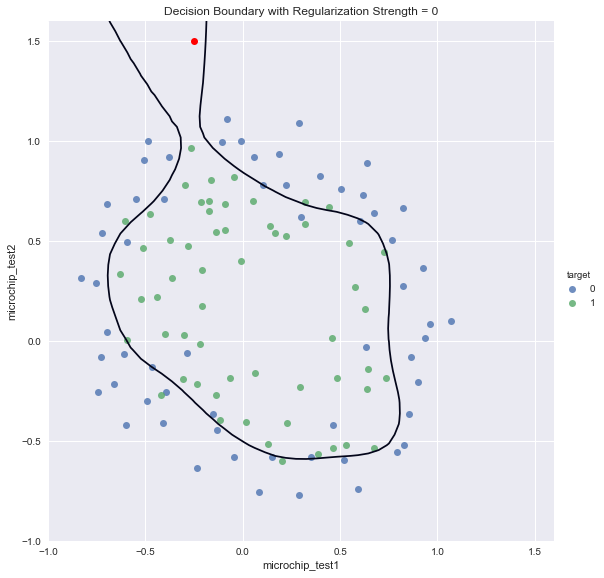

In [15]:
# plot decision boundary for regularization strength ~ 0
coef_reg_0=get_lr_coef(C=10^50000)
plot(coef_reg_0,0)
plt.plot(-0.25,1.5,'ro');